## Downloading Data

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedabdallah98","key":"05df623b311b1a8123f43cce3e4e80a2"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c fake-news

100% 46.5M/46.5M [00:03<00:00, 24.6MB/s]
100% 46.5M/46.5M [00:03<00:00, 16.0MB/s]


In [5]:
!mkdir Datasets
!unzip fake-news.zip -d Datasets

Archive:  fake-news.zip
  inflating: Datasets/submit.csv     
  inflating: Datasets/test.csv       
  inflating: Datasets/train.csv      


## Import libraries

In [6]:
import numpy as np
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import KFold
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")


import itertools
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Embedding, Activation, LSTM

# Reading Data and EDA

In [8]:
data = pd.read_csv('/content/Datasets/train.csv')

In [9]:
data.dropna(inplace =True)

In [10]:
X=data.drop(columns=['label'])

In [11]:
y = data['label']

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18285 non-null  int64 
 1   title   18285 non-null  object
 2   author  18285 non-null  object
 3   text    18285 non-null  object
dtypes: int64(1), object(3)
memory usage: 714.3+ KB


In [13]:
voc_size=5000

# Preprocessing

In [14]:
news_msg = data.copy()


In [15]:
news_msg.reset_index(inplace = True)

In [16]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(news_msg)):
    review = re.sub('[^a-zA-Z]', ' ', news_msg['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

### One Hot Representation

In [17]:
one_hot_rep=[one_hot(words,voc_size)for words in corpus] 
one_hot_rep

[[4708, 2481, 963, 2683, 2238, 3339, 2760, 2718, 1958, 4047],
 [1132, 1659, 3517, 167, 4999, 928, 1452],
 [1793, 888, 646, 220],
 [332, 4221, 2834, 4615, 4317, 4793],
 [1348, 4999, 196, 4230, 4941, 4492, 4999, 1838, 2493, 4088],
 [2465,
  3633,
  2752,
  2624,
  3361,
  3174,
  3235,
  1827,
  1659,
  1520,
  1435,
  3098,
  4961,
  1717,
  1452],
 [4410, 679, 2883, 3160, 3593, 1529, 3184, 846, 523, 1112, 53],
 [2274, 917, 3139, 3825, 1784, 4066, 3174, 3594, 523, 1112, 53],
 [4207, 4427, 4314, 462, 3339, 2694, 2999, 4532, 3174, 1359],
 [3142, 4911, 49, 856, 3557, 850, 4711, 3476],
 [87, 3683, 672, 4887, 661, 2533, 14, 3255, 3925, 2109, 2661],
 [4615, 4232, 2238, 2694, 3174, 1784],
 [143, 4866, 230, 1825, 3128, 730, 2592, 4054, 967],
 [3869, 4314, 2803, 3569, 2430, 1391, 1243, 523, 1112, 53],
 [1739, 4764, 1255, 186, 4471, 523, 1112, 53],
 [708, 3278, 2419, 4940, 815, 1691, 4995, 897, 1030, 45],
 [781, 2662, 1659],
 [2785, 3239, 3181, 1919, 3174, 371, 1446, 1452],
 [4234, 1862, 3517, 19

### Word_Embedding

In [18]:
sent_length=20
embedded_words=pad_sequences(one_hot_rep,padding='pre',maxlen=sent_length)
print(embedded_words)

[[   0    0    0 ... 2718 1958 4047]
 [   0    0    0 ... 4999  928 1452]
 [   0    0    0 ...  888  646  220]
 ...
 [   0    0    0 ...  523 1112   53]
 [   0    0    0 ... 1530 4052 4557]
 [   0    0    0 ... 3063 1739 4859]]


## Splitting Data

In [19]:
np.array(embedded_words),np.array(y)

(array([[   0,    0,    0, ..., 2718, 1958, 4047],
        [   0,    0,    0, ..., 4999,  928, 1452],
        [   0,    0,    0, ...,  888,  646,  220],
        ...,
        [   0,    0,    0, ...,  523, 1112,   53],
        [   0,    0,    0, ..., 1530, 4052, 4557],
        [   0,    0,    0, ..., 3063, 1739, 4859]], dtype=int32),
 array([1, 0, 1, ..., 0, 1, 1]))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(np.array(embedded_words),np.array(y), test_size=0.33, random_state=42)

## Applying Model : LSTM

In [155]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))

model.add(BatchNormalization())
model.add(LSTM(75))

model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=.001),metrics=['accuracy'])

In [156]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 20, 40)            200000    
                                                                 
 batch_normalization_14 (Bat  (None, 20, 40)           160       
 chNormalization)                                                
                                                                 
 lstm_14 (LSTM)              (None, 75)                34800     
                                                                 
 dropout_14 (Dropout)        (None, 75)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 76        
                                                                 
Total params: 235,036
Trainable params: 234,956
Non-trainable params: 80
______________________________________________

In [157]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=32)

Epoch 1/15
383/383 [==============================] - 5s 8ms/step - loss: 0.2306 - accuracy: 0.9008 - val_loss: 0.3835 - val_accuracy: 0.8389
Epoch 2/15
383/383 [==============================] - 3s 7ms/step - loss: 0.1098 - accuracy: 0.9569 - val_loss: 0.1975 - val_accuracy: 0.9160
Epoch 3/15
383/383 [==============================] - 3s 7ms/step - loss: 0.0429 - accuracy: 0.9865 - val_loss: 0.2816 - val_accuracy: 0.9109
Epoch 4/15
383/383 [==============================] - 3s 7ms/step - loss: 0.0197 - accuracy: 0.9934 - val_loss: 0.3522 - val_accuracy: 0.9171
Epoch 5/15
383/383 [==============================] - 3s 7ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.4123 - val_accuracy: 0.9143
Epoch 6/15
383/383 [==============================] - 3s 7ms/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.4358 - val_accuracy: 0.9127
Epoch 7/15
383/383 [==============================] - 3s 7ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.5186 - val_accuracy: 0.9143
Epoch 

In [158]:
y_pred=model.predict(X_test)

189/189 [==============================] - 1s 2ms/step


###Evaluation

In [159]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [160]:
f = y_pred>.5
y_pred=np.multiply(f, 1)

In [161]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3419
           1       0.89      0.91      0.90      2616

    accuracy                           0.91      6035
   macro avg       0.91      0.91      0.91      6035
weighted avg       0.91      0.91      0.91      6035

******************************************************************************************************************************************************

Accuracy score is  0.9138359569179785 

******************************************************************************************************************************************************

Confusion matrix, without normalization


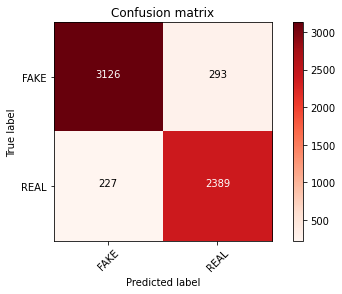

In [162]:
print(classification_report(y_test, y_pred))
print(150 * '*'+'\n')
score=accuracy_score(y_test,y_pred)
print("Accuracy score is " , score ,'\n')
print(150 * '*'+'\n')
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE','REAL']);